In [3]:
# Import necessary libraries
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import norm
from scipy.special import softmax

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import (
    roc_auc_score,
    classification_report, 
    confusion_matrix)
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedShuffleSplit,
    train_test_split)
from sklearn.preprocessing import OneHotEncoder

# Set a global seed for reproducability
SEED = 42
np.random.seed(SEED)

In [4]:
# Since there are some very small sample sizes all probabilities
# predicted by the model must be mapped to all possible classes
# even though all may not be represented in the current sample.
# This ensures consistent estimates and execution.
def get_full_proba(model, X, all_classes):
    """Generates prediction probabilities and pads them to match all_classes."""
    y_proba_subset = model.predict_proba(X)
    known_classes = model.classes_
    
    full_y_proba = np.zeros((y_proba_subset.shape[0], len(all_classes)))
    
    # Map the model's known classes to the correct column index in the full array
    for i, class_label in enumerate(known_classes):
        target_col_index = np.where(all_classes == class_label)[0][0]
        full_y_proba[:, target_col_index] = y_proba_subset[:, i]
        
    return full_y_proba

# Same reason as above but this time it is the OOB scores from the
# model that are used instead of the results on a test set.
def get_oob_proba(model, y_true, all_classes):
    """
    Generates prediction probabilities from OOB scores and pads them 
    to match all_classes. Converts OOB scores to proper probabilities.
    """
    if not hasattr(model, 'oob_decision_function_') or model.oob_decision_function_ is None:
        # Return uniform probabilities if OOB unavailable
        return np.full((len(y_true), len(all_classes)), 1/len(all_classes), dtype=float)
    
    oob_scores = model.oob_decision_function_
    known_classes = model.classes_
    
    # Convert OOB scores to probabilities using softmax
    oob_proba = softmax(oob_scores, axis=1)
    
    # Pad to match all_classes
    full_oob_proba = np.zeros((oob_scores.shape[0], len(all_classes)))
    for i, class_label in enumerate(known_classes):
        target_col_index = np.where(all_classes == class_label)[0][0]
        full_oob_proba[:, target_col_index] = oob_proba[:, i]
    
    return full_oob_proba


# Part of the Bias correction confidence interval. The bias correction factor,
# denoted 'w', is calculated for a bootstrap round.
def calculate_bias_correction_factor(bootstrap_estimates, original_estimate, B):
    less_than_mask = bootstrap_estimates < original_estimate
    frac = less_than_mask.sum() / B
    frac = np.clip(frac, 1e-10, 1 - 1e-10)
    return norm.ppf(frac)

# Part of the Bias correction confidence interval. The acceleration factor,
# denoted 'a', is calculated for a bootstrap round. The real estimation would
# use leave one out summations for each sample in n. To reduce data leakage
# this version uses the OOB scores from the random forest model to instead
# of using a separate test set for the evaluation. 
def calculate_acceleration_factor(X, y, model_parameters, all_classes, n_jackknife=None):
    n = X.shape[0]
    indices = np.arange(n)
    jackknife_estimates = np.zeros(len(indices))
    
    for i in indices:
        # Delete the current sample from the data
        # the 'leave one out' part
        X_jack = np.delete(X, i, axis=0)
        y_jack = np.delete(y, i, axis=0)
        
        # If the sample is small and only one class
        # is represented the estimate is 0.5
        if len(np.unique(y_jack)) < 2:
            jackknife_estimates[i] = 0.5
        else:
            model = RandomForestClassifier(**model_parameters)
            model.fit(X_jack, y_jack.ravel())
            y_proba = get_oob_proba(model, y_jack, all_classes)
            
            # Suppress warning for single-class OOB edge cases
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=UndefinedMetricWarning)
                try:
                    score = roc_auc_score(y_jack, y_proba, multi_class='ovr', average='macro', labels=all_classes)
                except ValueError:
                    score = 0.5
            jackknife_estimates[i] = score

    jack_mean = np.mean(jackknife_estimates)
    numerator = np.sum((jack_mean - jackknife_estimates) ** 3)
    denominator_sq = np.sum((jack_mean - jackknife_estimates) ** 2)
    
    # Avoid division by zero or a very small number which would 
    # only introduce numerical instability. In those cases the 
    # acceleration is approximately zero.
    if denominator_sq < 1e-10:
        return 0.0
    
    denominator = 6 * (denominator_sq ** 1.5)
    return numerator / denominator


In [ ]:
rf_synthetic_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'oob_score': True,
    'random_state': SEED,
    'n_jobs': -1
}

# Create Synthetic Data
# Make it lrage (N=10,000) to find the "True" Theoretical AUC
X_syn, y_syn = make_classification(n_samples=10000, n_features=8, n_informative=4, n_classes=6, random_state=SEED)
# Count the number of classes in the full dataset
all_classes = np.unique(y_syn)

# Define number of samples for subsampling
n_samples = 100

# Calulate the "True" Theoretical AUC by
# repeatedly sampling from the large synthetic dataset.
truths = np.zeros(n_samples)
for i in range(n_samples):
    idx = np.random.choice(range(10000), size=n_samples)

    X_subsample, y_subsample = X_syn[idx], y_syn[idx]

    # Calculate "True" AUC
    rf_true = RandomForestClassifier(**rf_synthetic_params)
    rf_true.fit(X_subsample, y_subsample)

    # Use the OOB probability function to get unbiased scores
    y_probs_oob = get_oob_proba(rf_true, y_subsample, all_classes)

    truths[i] = roc_auc_score(y_subsample, y_probs_oob, multi_class='ovr', average='macro', labels=all_classes)

TRUE_AUC = truths.mean()
print(f"True Theoretical AUC: {TRUE_AUC}")

# Simulation Loop (Coverage Check)
# Take small samples (n=100) and see if the BCa interval captures the True AUC
n_simulations = 100

coverage_count = 0

# Set the confidence level of the CI
alpha = 0.05
# Set number of bootstrap iterations
B = 500

for i in range(n_simulations):
    # Draw a small sample (n=100) from the big population
    idx = np.random.choice(range(10000), size=n_samples)
    X_subsample, y_subsample = X_syn[idx], y_syn[idx]
    
    # Initiate variable for the bootstrap loop
    bootstrap_roc_aucs = np.zeros(B)
    y_subsample_flat = y_subsample.ravel()

    # Calculate the original estimate (theta hat) for the subsample
    # Use the oob proba for the test score. 
    rf_subsample = RandomForestClassifier(**rf_synthetic_params)
    rf_subsample.fit(X_subsample, y_subsample.ravel())
    y_subsample_proba = get_oob_proba(rf_subsample, y_subsample, all_classes)

    # Hide warning which may occur for small n
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UndefinedMetricWarning)
        subsample_roc_auc_estimate = roc_auc_score(y_subsample, y_subsample_proba, multi_class='ovr', average='macro', labels=all_classes)


    # Create list of subsample indices
    indices_pool = np.arange(n_samples) 
    # Create list of all class indices 
    class_indices = {c: np.where(y_subsample_flat == c)[0] for c in np.unique(y_subsample_flat)}

    
    for b in range(B):
        # Generate the bootstrap sample and use the class indices to 
        # ensure a proportional sample of classes are drawn from the 
        # original subsample. The draws are with replacement.
        bootstrap_indices_list = []
        for c, cls_idxs in class_indices.items():
            if len(cls_idxs) > 0:
                bootstrap_indices_list.append(np.random.choice(cls_idxs, size=len(cls_idxs), replace=True))
        
        bootstrap_idx = np.concatenate(bootstrap_indices_list)
        
        # The test set (oob samples) are generated based on the indices
        # which were not drawn from the original sample. 
        test_idx = np.setdiff1d(indices_pool, bootstrap_idx)
        
        # If the draws from the test set are not representative then
        # continue to the next round. 
        if len(test_idx) == 0 or len(np.unique(y_subsample[test_idx])) < 2:
            bootstrap_roc_aucs[b] = 0.5 
            continue

        # Define the sets based on the previous indexing.
        X_boot_train = X_subsample[bootstrap_idx]
        y_boot_train = y_subsample[bootstrap_idx]
        X_boot_test = X_subsample[test_idx]
        y_boot_test = y_subsample[test_idx]

        # Create a model for the bootstrap iteration and fit the data.
        rf_best_bootstrap = RandomForestClassifier(**rf_synthetic_params)
        rf_best_bootstrap.fit(X_boot_train, y_boot_train.ravel())
        
        # Evaluate on the test set previously created.
        y_proba = get_full_proba(rf_best_bootstrap, X_boot_test, all_classes)
        
        # Ignore the terminal print of the warning which may occur for small n.
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            try:
                roc_auc = roc_auc_score(y_boot_test, y_proba, multi_class='ovr', average='macro', labels=all_classes)
            except ValueError:
                roc_auc = 0.5

        # If the result is nan then it is replaced with a proper
        # value to ensure the continuation of the experiment.
        if np.isnan(roc_auc):
            roc_auc = 0.5

        # Save the bootstrap iteration result
        bootstrap_roc_aucs[b] = roc_auc

    # Calculate the mean for the entire bootstrap session
    boot_mean = np.mean(bootstrap_roc_aucs)

    # Calculate the bias correction and acceleration factors for the
    # bias correction confidence interval.
    w = calculate_bias_correction_factor(bootstrap_roc_aucs, subsample_roc_auc_estimate, B)
    a = calculate_acceleration_factor(X_subsample, y_subsample, rf_synthetic_params, all_classes) 

    # Calculate the lambda threshold for the CI level.
    lambda_low  = norm.ppf(alpha / 2)       
    lambda_high = norm.ppf(1 - alpha / 2)   

    # The low and high z-scores for the percentile calculation
    z_low  = w + (lambda_low + w) / (1 - a * (lambda_low + w))
    z_high = w + (lambda_high + w) / (1 - a * (lambda_high + w))

    # The percentile calculations to determine their rank
    P_low  = norm.cdf(z_low) 
    P_high = norm.cdf(z_high)

    # Find the indices corresponding to the percentile ranks
    low_index = int(np.clip(np.floor(P_low * B), 0, B - 1))
    high_index = int(np.clip(np.floor(P_high * B), 0, B - 1))

    # Sort the scores to find the lower and higher bounds
    sorted_scores = np.sort(bootstrap_roc_aucs)
    
    # Final CI bounds
    CI_low  = sorted_scores[low_index]
    CI_high = sorted_scores[high_index]
    CI_mean = (CI_low + CI_high) / 2
    
    print(f"Simulation {i+1}/{n_simulations}: BCa CI = ({CI_low:.4f}, {CI_high:.4f}), Mean = {CI_mean:.4f}")

    # Check if it captured the truth
    if CI_low <= TRUE_AUC <= CI_high:
        coverage_count += 1
        
print(f"BCa Interval Coverage Probability: {coverage_count / n_simulations}")
# Ideally, it should be close to the 1-alpha = 0.95

True Theoretical AUC: 0.8340890960506288
Simulation 1/100: BCa CI = (0.8155, 0.9558), Mean = 0.8856
Simulation 2/100: BCa CI = (0.6851, 0.8491), Mean = 0.7671
Simulation 3/100: BCa CI = (0.6668, 0.8338), Mean = 0.7503
Simulation 4/100: BCa CI = (0.7817, 0.9262), Mean = 0.8539
Simulation 5/100: BCa CI = (0.7271, 0.8923), Mean = 0.8097
Simulation 6/100: BCa CI = (0.7047, 0.8627), Mean = 0.7837
Simulation 7/100: BCa CI = (0.7793, 0.9266), Mean = 0.8529
Simulation 8/100: BCa CI = (0.7139, 0.8892), Mean = 0.8016
Simulation 9/100: BCa CI = (0.6328, 0.8262), Mean = 0.7295
Simulation 10/100: BCa CI = (0.8222, 0.9423), Mean = 0.8822
Simulation 11/100: BCa CI = (0.7595, 0.9214), Mean = 0.8404
Simulation 12/100: BCa CI = (0.6965, 0.8569), Mean = 0.7767
Simulation 13/100: BCa CI = (0.7258, 0.8784), Mean = 0.8021
Simulation 14/100: BCa CI = (0.7452, 0.9103), Mean = 0.8277
Simulation 15/100: BCa CI = (0.7627, 0.9016), Mean = 0.8322
Simulation 16/100: BCa CI = (0.7987, 0.9427), Mean = 0.8707
Simulati

In [18]:
#Load the data from the csv file into a pandas DataFrame.
data = pd.read_csv('./data/Land mines.csv')
# Print some information about the dataset
data.info()
data.head()

# Determine the number of unique classes in the categorical feature 'S'
ohe_classes = len(data['S'].unique()) 
# Prepare the feature matrix X and target vector y.
X = np.zeros(shape=(data.shape[0], 2 + ohe_classes))

# Populate the feature matrix X and target vector y
# with data. Features 'V' and 'H' are numerical and can be used directly.
X[:,0] = data['V'].values
X[:,1] = data['H'].values
# THe third feature 'S' is categorical and needs to be one-hot encoded.
X[:,2:] = OneHotEncoder(sparse_output=False).fit_transform(data['S'].values.reshape(-1,1))

# y is the target.
y = data['M'].values.reshape(-1, 1)

# Generate train-test split for the parameter search. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V       338 non-null    float64
 1   H       338 non-null    float64
 2   S       338 non-null    int64  
 3   M       338 non-null    int64  
dtypes: float64(2), int64(2)
memory usage: 10.7 KB


In [19]:
# Check class balance in the full dataset
all_mines = y.ravel()
mine_types = np.unique(all_mines)
mine_types_count = dict()
for mine in all_mines:
    if mine in mine_types_count:
        mine_types_count[mine] += 1
    else:
        mine_types_count[mine] = 1

mine_types_freq = dict()
for c, count in mine_types_count.items():
    mine_types_freq[c] = np.round(count / len(all_mines), 4)

print("Class balance in the full dataset")
print("-" * 65)
for c in mine_types:
    print(f"Class: {c:<3} | Count: {mine_types_count.get(c)}  | Percentage:  {np.mean(100*mine_types_freq.get(c)):.2f}%")
print(f"Total: {len(mine_types):<3} | Count: {sum(mine_types_count.values())} | Percentage: {100*sum(mine_types_freq.values()):.2f}%")
print("-" * 65)



Class balance in the full dataset
-----------------------------------------------------------------
Class: 1   | Count: 71  | Percentage:  21.01%
Class: 2   | Count: 70  | Percentage:  20.71%
Class: 3   | Count: 66  | Percentage:  19.53%
Class: 4   | Count: 66  | Percentage:  19.53%
Class: 5   | Count: 65  | Percentage:  19.23%
Total: 5   | Count: 338 | Percentage: 100.01%
-----------------------------------------------------------------


In [5]:
# Define the parameter grid
param_grid = {
    'n_estimators': [10, 25, 50, 100, 200, 300, 500],   # Number of trees
    'max_depth': [5, 10, 15, 20, None],                 # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],                    # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3, 4, 5],                # Minimum number of samples required to be at a leaf node
    'criterion': ['gini', 'entropy', 'log_loss'],       # Function to measure the quality of a split
    'max_features': [0.3, 0.5, 0.7, 'sqrt', 'log2'],    # Number of features to consider at every split
    'class_weight': ['balanced', None]                  # Weights associated with classes
}

# Initiate the model and then use grid search with the parameters above
# to find the optimal setting for the data.
rf = RandomForestClassifier(random_state=SEED)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc_ovr',  # Use 'roc_auc' as evaluation
    cv=10,                  # Use 10-fold Cross-Validation
    n_jobs=-1               # Split up work among available CPU cores
)

# Fit the grid search on the training data to find 
# the optimal setting.
grid_search.fit(X_train, y_train.ravel())

# This is the best model
best_rf = grid_search.best_estimator_

# It is used to make a prediction on the test set
# to obtain information about the performance
y_pred = best_rf.predict(X_test)
y_probs = best_rf.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_probs, multi_class='ovr', average='macro')

# Save the best parameters into a variable
best_params = grid_search.best_params_

# Print information about the results from the best Random Forest model
print("Confusion Matrix and Classification Report for Best Random Forest Model:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc:.4f}")
print("Best Random Forest Parameters:")
print(best_params)

Confusion Matrix and Classification Report for Best Random Forest Model:
[[10  0  1  0  0]
 [ 0 11  0  1  0]
 [ 2  0 10  2  2]
 [ 0  1  0  6  4]
 [ 3  0  7  4  4]]
              precision    recall  f1-score   support

           1       0.67      0.91      0.77        11
           2       0.92      0.92      0.92        12
           3       0.56      0.62      0.59        16
           4       0.46      0.55      0.50        11
           5       0.40      0.22      0.29        18

    accuracy                           0.60        68
   macro avg       0.60      0.64      0.61        68
weighted avg       0.58      0.60      0.58        68

ROC AUC Score: 0.8663
Best Random Forest Parameters:
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}


In [20]:
def BCa_bootstrap_experiment(X, y, rf_best_params, all_classes, ns, B=1000, alpha=0.05, bootstrap_distribution=None):
    print(f"Total Training Samples available: {X.shape[0]}")
    print(f"Using bootstrap distribution: {bootstrap_distribution}")
    print(f"Starting BCa Bootstrap (B={B})...")
    print("-" * 65)

    # Define a matrix to hold all experiment results
    n_results = np.zeros((len(ns), 6)) 

    # The experiment loop for each n in ns
    for idx, n in enumerate(ns):
        
        # Define the current set of n samples from
        # the full data.
        if n >= n_samples:
            # Instead of crashing, use the full data if n > sample size
            X_subsample = X
            y_subsample = y
            current_n = n_samples # Update correct size
        else:
            # Generate a Stratified Subsample with n datapoints from the 
            # full data. The StratifiedShuffleSplit keeps the proportion of 
            # samples among the classes.
            sss = StratifiedShuffleSplit(n_splits=1, train_size=n, random_state=SEED)
            for train_index, test_index in sss.split(X, y):
                X_subsample = X[train_index]
                y_subsample = y[train_index]
            current_n = X_subsample.shape[0]

        # Calculate the original estimate (theta hat) for the subsample
        # Use the oob proba for the test score. 
        rf_subsample = RandomForestClassifier(**rf_best_params)
        rf_subsample.fit(X_subsample, y_subsample.ravel())
        y_subsample_proba = get_oob_proba(rf_subsample, y_subsample, all_classes)
        
        # Hide warning which may occur for small n
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            subsample_roc_auc_estimate = roc_auc_score(y_subsample, y_subsample_proba, multi_class='ovr', average='macro', labels=all_classes)

        # Initiate variable for the bootstrap loop
        bootstrap_roc_aucs = np.zeros(B)
        y_subsample_flat = y_subsample.ravel()
        
        # Create list of subsample indices
        indices_pool = np.arange(current_n) 
        # Create list of all class indices 
        class_indices = {c: np.where(y_subsample_flat == c)[0] for c in np.unique(y_subsample_flat)}

        for b in range(B):
            if bootstrap_distribution == 'non-parametric':
                # Generate the bootstrap sample and use the class indices to 
                # ensure a proportional sample of classes are drawn from the 
                # original subsample. The draws are with replacement.
                bootstrap_indices_list = []
                for c, cls_idxs in class_indices.items():
                    if len(cls_idxs) > 0:
                        bootstrap_indices_list.append(np.random.choice(cls_idxs, size=len(cls_idxs), replace=True))
                
                bootstrap_idx = np.concatenate(bootstrap_indices_list)

                # Create training set based on the indices
                X_boot_train = X_subsample[bootstrap_idx]
                y_boot_train = y_subsample[bootstrap_idx]

            if bootstrap_distribution == 'parametric':
                # Create the parametric bootstrap sample based on the model's
                # predicted probabilities for each class.
                # THe indices are drawn with replacement to keep the sample size the same.
                bootstrap_idx = np.random.choice(indices_pool, size=current_n, replace=True)
                
                # Generate new y values for the indices based on the model's probabilities
                y_new_list = []
                for i in bootstrap_idx:
                    # Use the probability from the original subsample fit for index i
                    new_label = np.random.choice(all_classes, p=y_subsample_proba[i])
                    y_new_list.append(new_label)
                
                # Create training set based on the indices
                X_boot_train = X_subsample[bootstrap_idx]
                y_boot_train = np.array(y_new_list).reshape(-1, 1)

            # The test set (oob samples) are generated based on the indices
            # which were not drawn from the original sample. 
            test_idx = np.setdiff1d(indices_pool, bootstrap_idx)
            
            # If the draws from the test set are not representative then
            # continue to the next round. 
            if len(test_idx) == 0 or len(np.unique(y_subsample[test_idx])) < 2:
                bootstrap_roc_aucs[b] = 0.5 
                continue

            # Define the sets based on the previous indexing.
            X_boot_test = X_subsample[test_idx]
            y_boot_test = y_subsample[test_idx]

            # Create a model for the bootstrap iteration and fit the data.
            rf_best_bootstrap = RandomForestClassifier(**rf_best_params)
            rf_best_bootstrap.fit(X_boot_train, y_boot_train.ravel())
            
            # Evaluate on the test set previously created.
            y_proba = get_full_proba(rf_best_bootstrap, X_boot_test, all_classes)
            
            # Ignore the terminal print of the warning which may occur for small n.
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=UndefinedMetricWarning)
                try:
                    roc_auc = roc_auc_score(y_boot_test, y_proba, multi_class='ovr', average='macro', labels=all_classes)
                except ValueError:
                    roc_auc = 0.5

            # If the result is nan then it is replaced with a proper
            # value to ensure the continuation of the experiment.
            if np.isnan(roc_auc):
                roc_auc = 0.5

            # Save the bootstrap iteration result
            bootstrap_roc_aucs[b] = roc_auc

        # Calculate the mean for the entire bootstrap session
        boot_mean = np.mean(bootstrap_roc_aucs)

        # Calculate the bias correction and acceleration factors for the
        # bias correction confidence interval.
        w = calculate_bias_correction_factor(bootstrap_roc_aucs, subsample_roc_auc_estimate, B)
        a = calculate_acceleration_factor(X_subsample, y_subsample, rf_best_params, all_classes) 

        # Calculate the lambda threshold for the CI level.
        lambda_low  = norm.ppf(alpha / 2)       
        lambda_high = norm.ppf(1 - alpha / 2)   

        # The low and high z-scores for the percentile calculation
        z_low  = w + (lambda_low + w) / (1 - a * (lambda_low + w))
        z_high = w + (lambda_high + w) / (1 - a * (lambda_high + w))

        # The percentile calculations to determine their rank
        P_low  = norm.cdf(z_low) 
        P_high = norm.cdf(z_high)

        # Find the indices corresponding to the percentile ranks
        low_index = int(np.clip(np.floor(P_low * B), 0, B - 1))
        high_index = int(np.clip(np.floor(P_high * B), 0, B - 1))

        # Sort the scores to find the lower and higher bounds
        sorted_scores = np.sort(bootstrap_roc_aucs)
        
        # Final CI bounds
        CI_low  = sorted_scores[low_index]
        CI_high = sorted_scores[high_index]
        CI_mean = (CI_low + CI_high) / 2

        # Output
        print(f"n={n:<3}  | Theta_hat: {subsample_roc_auc_estimate:.4f} | Boot Mean: {np.mean(bootstrap_roc_aucs):.4f}")
        print(f"       | w={w:.4f} | a={a:.4f} | P_low={P_low:.4f} | P_high={P_high:.4f}")
        print(f"       | BCa CI: [{CI_low:.4f}, {CI_high:.4f}]")
        print("-" * 65)

        # Save the result to matrix
        n_results[idx, :] = [current_n, subsample_roc_auc_estimate, boot_mean, CI_low, CI_high, CI_mean]


    print(f"Experiment finished.")
    print("-" * 65)

    return n_results

In [ ]:
# Define the best parameters, found previously, as a parameter dict
rf_best_params = {
    'n_estimators': 500,
    'criterion': 'entropy',
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
    'max_features': 0.7,
    'class_weight': 'balanced',
    'random_state': SEED,
    'oob_score': True,
    'n_jobs': -1
}

# Count the number of classes in the full dataset
all_classes = np.unique(y)
# Count the number of samples in the full dataset
n_samples = X.shape[0]
# Set the confidence level of the CI
alpha = 0.05
# Set the number of bootstrap iterations
B = 3000
# Define a list of sample sizes to evaluate
ns = [25, 50, 75, 100, 150, 200, 250, n_samples]


# Run the experiment for Non-Parametric Bootstrap
n_non_parametric_results = BCa_bootstrap_experiment(
    X, y, rf_best_params, all_classes, ns, B=B, alpha=alpha, bootstrap_distribution='non-parametric'
)
try:
    # Save results to CSV
    results_df = pd.DataFrame(n_non_parametric_results, columns=[
        'n_samples', 'Theta_hat', 'Boot_Mean', 'CI_Low', 'CI_High', 'CI_Mean'
    ])
    results_df.to_csv('./experiment_non_parametric_results.csv', index=False)
except Exception as e:
    print(f"Error saving results to CSV: {e}")


# Run the experiment for Parametric Bootstrap
n_parametric_results = BCa_bootstrap_experiment(
    X, y, rf_best_params, all_classes, ns, B=B, alpha=alpha, bootstrap_distribution='parametric'
)
try:
    # Save results to CSV
    results_df = pd.DataFrame(n_parametric_results, columns=[
        'n_samples', 'Theta_hat', 'Boot_Mean', 'CI_Low', 'CI_High', 'CI_Mean'
    ])
    results_df.to_csv('./experiment_parametric_results.csv', index=False)
except Exception as e:
    print(f"Error saving results to CSV: {e}")

Total Training Samples available: 338
Using bootstrap distribution: parametric
Starting BCa Bootstrap (B=3000)...
-----------------------------------------------------------------
n=25   | Theta_hat: 0.6040 | Boot Mean: 0.5329
       | w=0.7835 | a=-0.0225 | P_low=0.3354 | P_high=0.9996
       | BCa CI: [0.5000, 0.9381]
-----------------------------------------------------------------
n=50   | Theta_hat: 0.6935 | Boot Mean: 0.5808
       | w=1.0684 | a=-0.0015 | P_low=0.5697 | P_high=1.0000
       | BCa CI: [0.6026, 0.9212]
-----------------------------------------------------------------
n=75   | Theta_hat: 0.7253 | Boot Mean: 0.5932
       | w=1.5863 | a=-0.0024 | P_low=0.8873 | P_high=1.0000
       | BCa CI: [0.6946, 0.8487]
-----------------------------------------------------------------
n=100  | Theta_hat: 0.7501 | Boot Mean: 0.6036
       | w=2.1280 | a=0.0003 | P_low=0.9892 | P_high=1.0000
       | BCa CI: [0.7615, 0.8136]
-------------------------------------------------------

Comparison plots saved to: /home/andreas/CIS/project/images


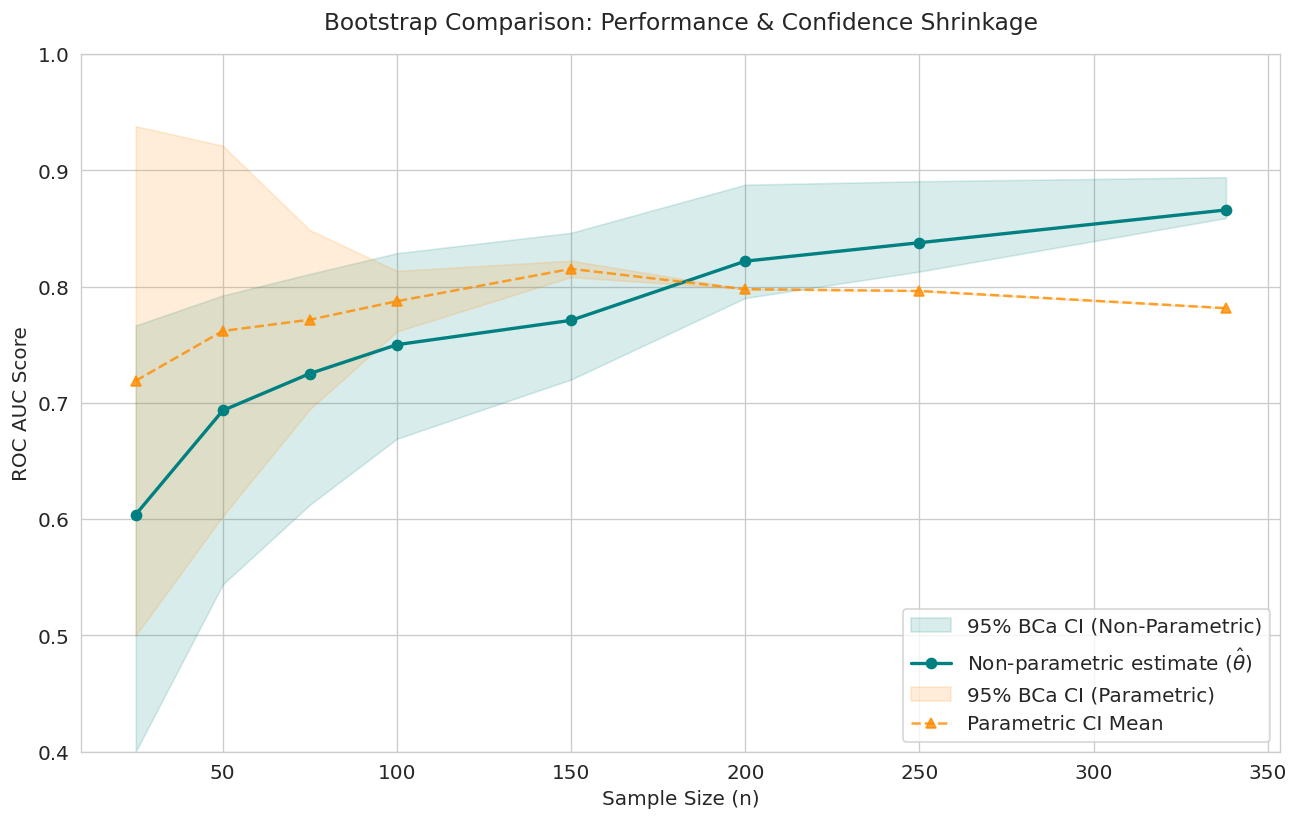

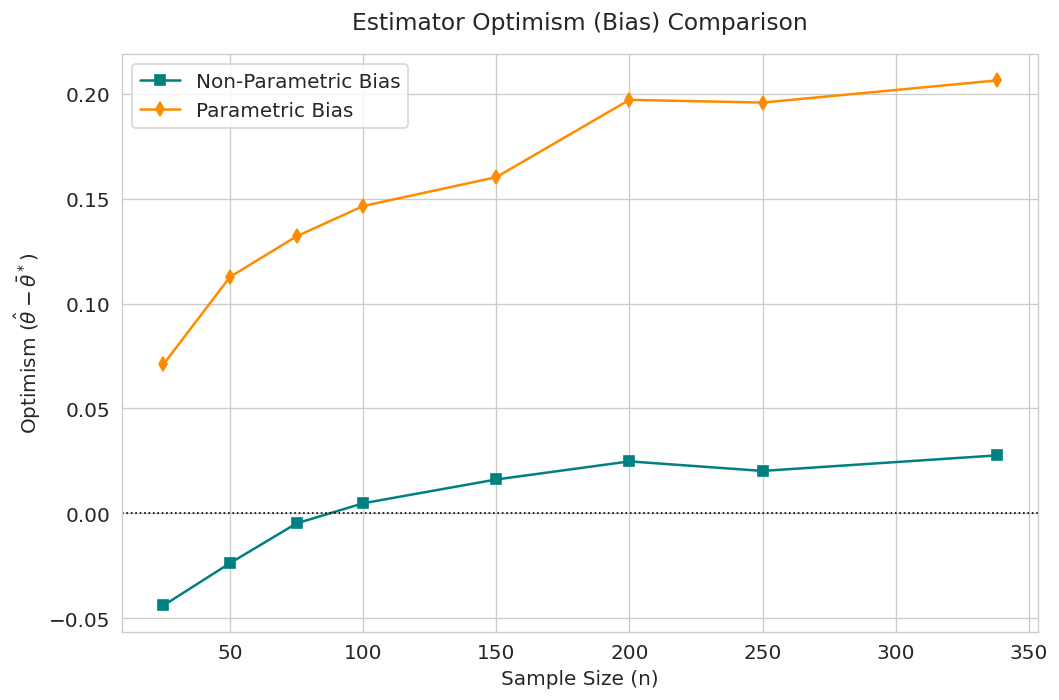

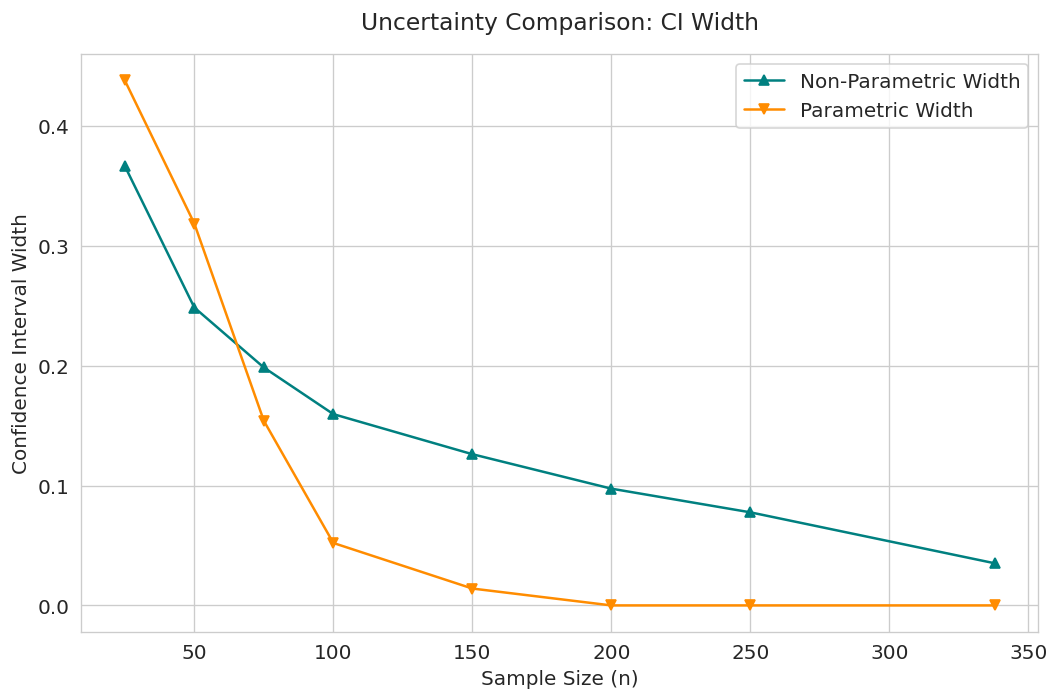

In [28]:
# Ensure the output directory exists
output_dir = 'images'
os.makedirs(output_dir, exist_ok=True)

# Load the dataframes
try:
    df_np = pd.read_csv('./experiment_non_parametric_results.csv')
    df_p = pd.read_csv('./experiment_parametric_results.csv')
except FileNotFoundError as e:
    print(e)

# Set style for academic reporting
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12, 'figure.dpi': 120})

# --- Plot 1: Performance & Confidence Band Comparison ---
plt.figure(figsize=(11, 7))

# 1. Plot Non-Parametric (Original)
plt.fill_between(df_np['n_samples'], df_np['CI_Low'], df_np['CI_High'], 
                 color='teal', alpha=0.15, label='95% BCa CI (Non-Parametric)')
plt.plot(df_np['n_samples'], df_np['Theta_hat'], color='teal', linewidth=2, 
         marker='o', label=r'Non-parametric estimate ($\hat{\theta}$)')

# 2. Plot Parametric
plt.fill_between(df_p['n_samples'], df_p['CI_Low'], df_p['CI_High'], 
                 color='darkorange', alpha=0.15, label='95% BCa CI (Parametric)')
plt.plot(df_p['n_samples'], df_p['CI_Mean'], color='darkorange', linestyle='--', 
         linewidth=1.5, marker='^', alpha=0.8, label='Parametric CI Mean')

plt.title('Bootstrap Comparison: Performance & Confidence Shrinkage', fontsize=14, pad=15)
plt.ylabel('ROC AUC Score')
plt.xlabel('Sample Size (n)')
plt.legend(loc='lower right', frameon=True)
plt.ylim(0.4, 1.0) 

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'comparison_performance_shrinkage.png'))

# --- Plot 2: Bias (Optimism) Comparison ---
plt.figure(figsize=(9, 6))

bias_np = df_np['Theta_hat'] - df_np['Boot_Mean']
bias_p = df_p['Theta_hat'] - df_p['Boot_Mean']

plt.plot(df_np['n_samples'], bias_np, color='teal', marker='s', label='Non-Parametric Bias')
plt.plot(df_p['n_samples'], bias_p, color='darkorange', marker='d', label='Parametric Bias')
plt.axhline(0, color='black', linestyle=':', linewidth=1)

plt.title('Estimator Optimism (Bias) Comparison', fontsize=14, pad=15)
plt.ylabel(r'Optimism ($\hat{\theta} - \bar{\theta}^*$)')
plt.xlabel('Sample Size (n)')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'comparison_bias.png'))

# --- Plot 3: CI Width (Uncertainty) Comparison ---
plt.figure(figsize=(9, 6))

width_np = df_np['CI_High'] - df_np['CI_Low']
width_p = df_p['CI_High'] - df_p['CI_Low']

plt.plot(df_np['n_samples'], width_np, color='teal', marker='^', label='Non-Parametric Width')
plt.plot(df_p['n_samples'], width_p, color='darkorange', marker='v', label='Parametric Width')

plt.title('Uncertainty Comparison: CI Width', fontsize=14, pad=15)
plt.ylabel('Confidence Interval Width')
plt.xlabel('Sample Size (n)')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'comparison_ci_width.png'))

print(f"Comparison plots saved to: {os.path.abspath(output_dir)}")